<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Anomaly Detection & Recommender Systems
</h1><br>
In the first part, we'll implement the *Anomaly Detection* algorithm and apply it to detect failing servers on a network. In the second part, we'll use *Collaborative Filtering* to build a recommender system for movies.

In [1]:
import numpy as np
from numpy.linalg import pinv, det
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat, whosmat
import scipy.optimize as opt
import seaborn as sns
from warnings import filterwarnings

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
filterwarnings('ignore')

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Functions
</h2><br>
We'll write here all the functions needed.

In [2]:
# Compute guassian distribution fn
def gaussian_estimate(Xtrain, Xval, gaussian_type="univariate"):
    """
    Xtrain: training feature matrix m x n that has only normal examples
    Xval: cross validation feature matrix that has anomalous and normal examples
    gussian_type: univariate or multivariate
    Return: pdf vector n x 1 of Xval
    """
    # number of training examples and features
    m, n = Xtrain.shape
    # number of cv examples
    mval = Xval.shape[0]

    # compute mean and covariance matrix
    mu = Xtrain.mean(axis=0)
    cov = (1 / (m)) * (Xtrain - mu).T.dot(Xtrain - mu)

    # convert the covariance matrix to diagonal if it"s a univariate
    if gaussian_type == "univariate":
        z = np.zeros_like(cov)
        np.fill_diagonal(z, np.diagonal(cov))
        cov = z

    # compute determinant and inverse of covariance matrix
    cov_det = det(cov)
    cov_inv = pinv(cov)

    # compute pdf vector
    p = ((2 * np.pi) ** (-n / 2)) * (cov_det ** (-0.5)) *\
        np.exp(-0.5 * np.sum(np.multiply((Xval - mu).dot(cov_inv), (Xval - mu)), axis=1))

    return p


# Hyperparameter tuning of epsilon using cv dataset
def select_threshold(yval, pval):
    """
    yval: label whether a validation example is normal (0) or anomaly (1)
    pval: pdf for validated examples
    Return: best epsilon value and its F1 score using CV data
    """
    # initialize epsilon and F1 score values
    best_epsilon = 0
    best_F1 = 0

    # compute stepsize for each iteration
    epsilon_stepsize = (pval.max() - pval.min()) / 1000

    for epsilon in np.arange(pval.min(), pval.max(), epsilon_stepsize):
        # get predictions vector
        pred = ((pval < epsilon) * 1).reshape(-1, 1)

        # compute true positives, false positives, false negatives
        tp = np.sum((pred == 1) & (yval == 1))
        fp = np.sum((pred == 1) & (yval == 0))
        fn = np.sum((pred == 0) & (yval == 1))

        # compute precision and recall
        precision_ = tp / (tp + fp)
        recall_ = tp / (tp + fn)

        # compute F1 score
        F1 = 2 * ((precision_ * recall_) / (precision_ + recall_))
        # if F1 score > best_F1, set best_F1 = F1
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon

    return best_epsilon, best_F1


# Def cost fn for collaborative filtering
def compute_cost(params, Y, R, num_users, num_movies, num_features, lambda_):
    """
    params: Includes theta and feature matrices all flattened in one vector
    Y: rating matrix of shape: num_movies x num_users
    R: matrix of shape: num_movis x num_users
        where R(i, j) = 1 if the user j rated the movie i; otherwise 0
    lambda_: regularization parameter
    Return: cost of regularized linear fn where theta and feature matrix is regularized
    """
    # Reshape params vector to get theta and feature matrix
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    theta = params[num_movies * num_features:].reshape(num_users, num_features)

    # compute the cost
    pred = X.dot(theta.T)
    # multiply element-wise error matrix with R matrix to include only rated movies
    error_matrix = np.multiply(pred - Y, R)
    J = (1 / 2) * np.square(error_matrix).sum() + (lambda_ / 2) * np.square(theta).sum() +\
        (lambda_ / 2) * np.square(X).sum()

    return J


# Def gradients for collaborative filtering
def gradient(params, Y, R, num_users, num_movies, num_features, lambda_):
    """
    params: Includes theta and feature matrices all flattened in one vector
    Y: rating matrix of shape: num_movies x num_users
    R: matrix of shape: num_movis x num_users
        where R(i, j) = 1 if the user j rated the movie i; otherwise 0
    lambda_: regularization parameter
    Return: regularized gradients of theta and feature matrices
    """
    # Reshape params vector to get theta and feature matrix
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    theta = params[num_movies * num_features:].reshape(num_users, num_features)
    pred = X.dot(theta.T)
    error_matrix = np.multiply(pred - Y, R)
    # theta gradient
    theta_grad = error_matrix.T.dot(X) + lambda_ * theta
    # feature gradient
    X_grad = error_matrix.dot(theta) + lambda_ * X

    return np.concatenate((X_grad, theta_grad)).ravel()


# Compute numerical gradients to be compared with analytical gradients
def numerical_gradient(params, Y, R, num_users, num_movies, num_features, lambda_):
    """
    params: Includes theta and feature matrices all flattened in one vector
    Y: rating matrix of shape: num_movies x num_users
    R: matrix of shape: num_movis x num_users
        where R(i, j) = 1 if the user j rated the movie i; otherwise 0
    lambda_: regularization parameter
    Return: numerical gradient
    """
    numgrad = np.zeros_like(params)
    perturb = np.zeros_like(params)
    epsilon = 1e-4
    for i in range(len(params)):
        perturb[i] = epsilon
        loss1 = compute_cost(params - perturb, Y, R, num_users,
                             num_movies, num_features, lambda_)
        loss2 = compute_cost(params + perturb,  Y, R,
                             num_users, num_movies, num_features, lambda_)

        numgrad[i] = (loss2 - loss1) / (2 * epsilon)
        perturb[i] = 0

    return numgrad


# Compute theta and featutre matrices
def compute_params(Y, R, num_users, num_movies, num_features, lambda_, max_iter=100):
    """
    Y: rating matrix of shape: num_movies x num_users
    R: matrix of shape: num_movis x num_users
        where R(i, j) = 1 if the user j rated the movie i; otherwise 0
    lambda_: regularization parameter
    Return: learned theta and feature matrics
    """
    # initialize theta and feature matrices
    X = np.random.randn(num_movies * num_features)
    theta = np.random.randn(num_users * num_features)

    # flatten both theta and feature matrices into one vector
    params = np.concatenate((X, theta)).ravel()

    # use scipy"s nonlinear conjugate gradient algorithm to learn params
    params_fitted = opt.fmin_cg(f=compute_cost, x0=params, fprime=gradient,
                                args=(Y, R, num_users, num_movies, num_features, lambda_), maxiter=max_iter)

    X = params_fitted[:num_movies *
                      num_features].reshape(num_movies, num_features)
    theta = params_fitted[num_movies *
                          num_features:].reshape(num_users, num_features)

    return X, theta


# Normalize ratings
def normalize_ratings(Y, R):
    """
    Y: rating matrix of shape: num_movies x num_users
    R: matrix of shape: num_movis x num_users
        where R(i, j) = 1 if the user j rated the movie i; otherwise 0
    Return: mean vector for all movies normalized version of ratings matrix
    """
    # number of movies
    m = Y.shape[0]
    # initialize Y_mean & Y_normal
    Y_mean = np.zeros(m)
    Y_normal = np.zeros_like(Y)

    for i in range(m):
        idx = np.where(R[i, :] == 1)
        Y_mean[i] = np.mean(Y[i, idx])
        Y_normal[i, idx] = Y[i, idx] - Y_mean[i]

    return Y_mean, Y_normal

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Anomaly Detection
</h2><br>
Anomaly Detection is the identification of examples or events that don't confront to an expected pattern or the majority of examples. Roughly speaking, it's the process of identifying an example that is not *normal (outlier)* given the distribution of the data. **Outlier** is an example that deviates so much from the other examples that arouse suspicions that it was generated by different data generating process. Mainly, such outliers would have a very low probability (on the very end of both left and right tails of the probability density function) that they belong to the same data generating process.

The algorithm works as follows:
1. Fit a *Gaussian Probability Density Function (PDF)* for each feature in the training dataset.
    1. Calculate the mean and the variance of each feature:
    $$\mu_j = \frac{1}{m}\sum_{i = 1}^mx_j^i\\{}$$
    $$\sigma^2_j = \frac{1}{m}\sum_{i = 1}^m(x_j^i - \mu_j)^2\\{}$$
    Where $\mu$ is the mean and $\sigma^2$ is the variance that controls the shape of the density function.
    2. Compute the density function for each feature using the following formula:   
$$p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x - \mu)^2}{2\sigma^2}}\\{}$$
Since the mean and the variance are sensitive to outliers, we use training dataset that has only normal examples to fit the model and calculate both the mean vector and the covariance matrix.
2. Compute the gaussian density by taking the product of all features' density functions.
3. If $p(x) < \epsilon$ then anomaly; otherwise, normal. Epsilon controls how sensitive the detection algorithm is. If $\epsilon$ is large $\rightarrow$ flag a lot of the examples as anomalous and that would increase the *False Positives*. However, If $\epsilon$ is small $\rightarrow$ very small portion of the examples will be flagged as anomalous and that would increase the *False Negatives*.
4. Use *Cross Validation* for tuning the hyper-parameter $\epsilon$ that yields the best performance metrics value. F1 score is commonly used:
$$F_1 = 2 \frac{precision * recall}{precision + recall}\\{}$$
Where:$$precision = \frac{tp}{tp + fp}\\{}$$
$$recall = \frac{tp}{tp + fn}\\{}$$
*tp: True Positive, fp: False Positive, fn: False Negative*.

We have two kinds of anomaly detection algorithms:
1. **Univariate Gaussian Density Function**
$$p(x) = \prod_{j = 1}^{n}p(x_j; \mu_j, \sigma_j^2)\\{}$$
$$ = p(x_1; \mu_1, \sigma_1^2)*p(x_2; \mu_2, \sigma_2^2)* ... * p(x_n; \mu_n, \sigma_j^n)\\{}$$
    * It assumes that all features are independent. Therefore, the covariance between all pairs of features is zero.
    * It's computationally faster and more efficient.
    * Use it if we have very large number of features.
    * Make sure to add features manually that captures unusual values for combination of features; such as $x_3 = \frac {x_2}{x_1}$. Otherwise, the algorithm may fail to detect anomalies that takes values that are considered normal when looked at each feature separately but are unusual when looking at values of all features together such as having high value for feature 2 compared to low value for feature 1.

2. **Multivariate Gaussian Density Function**
$$p(x) = \prod_{j = 1}^{n}p(x_j; \mu_j, \sigma_j^2)\\{}$$
$$p(x; \mu, \sigma^2) = \frac{1}{(2\pi)^{(n / 2)}(\det\sum)^{1 / 2}}e^{\frac{-1}{2}(x - \mu)^T\sum^{-1}(x - \mu)}\\{}$$
Where $\sum$ is n x n covariance matrix:
$$\sum = \begin{bmatrix}
\sigma_1^2&\sigma_{12}&\cdots&\sigma_{1n}\\
\sigma_{21}&\sigma_2^2&\cdots&0\\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{n1} & 0 & 0 & \sigma_n^2
\end{bmatrix}$$
Where $\sigma_{12} = \sigma_{21}$ is the covariance between features 1&2. Therefore, the covariance matrix is *symmetric positive (semi) definite*.
    * Computationally expensive
    * Use it when number of examples $\geq$ 10 times number of features, i.e. $m \geq 10n$
    * If some features are linearly dependent or number of examples is less than number of features $\rightarrow$ covariance matrix won't be invertible
    * No need to add more features to capture unusual values of combination of features because it captures that through covariances of all pairs of features
    * Univariate density function can be derived from Multivariate density function where covariance matrix would be a diagonal matrix. Therefore, $\sigma_{ij} = 0$ for all $i \neq j$

In this exercise, we'll implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While servers were operating, $m = 307$ examples of how they were behaving were captured. We suspect that the vast majority of them are normal (non-anomalous) examples of the servers operating normally.

Let's first load and plot the data:

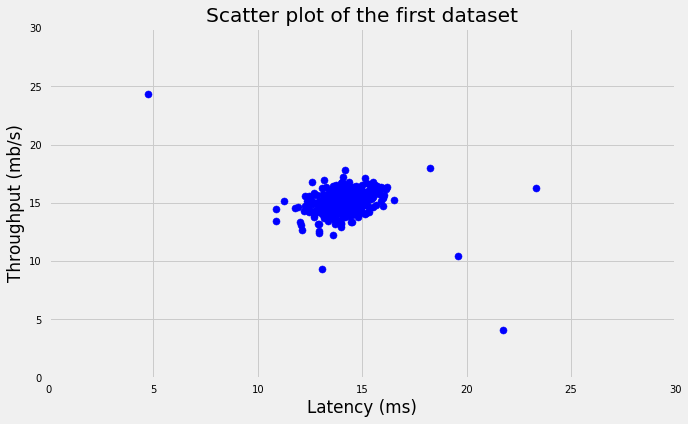

In [3]:
# Load data
data = loadmat("../data/ex8data1.mat")

# Training data
X = data["X"]

# Cross validation data
Xval = data["Xval"]
yval = data["yval"]

# Plot data
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(X[:, 0], X[:, 1], s = 50, c = "blue")
plt.axis([0, 30, 0, 30])
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.title("Scatter plot of the first dataset");

Now, we'll first estimate the Gaussian distribution for both the training and cross validation sets. Note that we use training dataset that has ONLY normal examples when computing mean and covariance and then use cross validation that has both normal and anomalous examples to know the best epsilon.

In [4]:
# Fit guassian distribution on both training and CV examples
ptrain = gaussian_estimate(X, X)
pval = gaussian_estimate(X, Xval, gaussian_type="multivariate")

# Tune epsilon
epsilon, F1 = select_threshold(yval, pval)
print(f"The best epsilon tuned using CV that yielded the best F1-score {F1:.3f} is: {epsilon}.")

The best epsilon tuned using CV that yielded the best F1-score 0.875 is: 9.065769728392737e-05.


We'll use the value of epsilon that we tuned using CV to see what examples were anomalous based on our algorithm. Below is the scatter plot of the training data where red points are anomalous examples. 

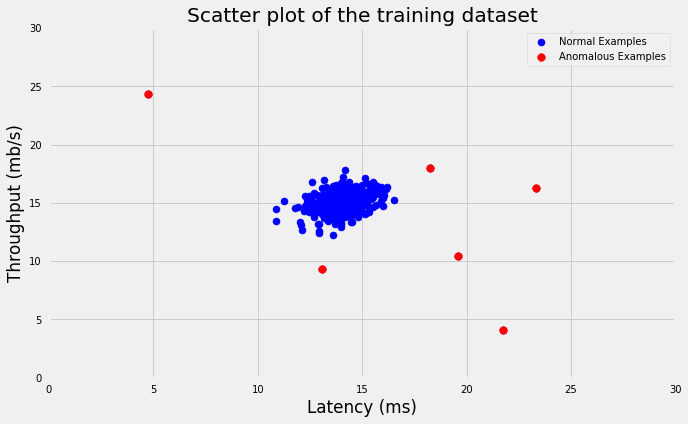

In [5]:
# Get the index of the outlier
outliers = np.where(ptrain < epsilon)

# Plot data
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, c="blue", label="Normal Examples")
plt.scatter(X[outliers[0], 0], X[outliers[0], 1], s=60, c="red", label="Anomalous Examples")
plt.axis([0, 30, 0, 30])
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.legend(loc="upper right")
plt.title("Scatter plot of the training dataset");

Finally, we'll try to fit Gaussian distribution on training dataset that has 1000 examples and 11 features. Note that in both examples we used *Multivariate* not *Univariate* Gaussian distribution. 

In [6]:
# Load data
data = loadmat('../data/ex8data2.mat')

# Training data
X = data['X']

# Cross validation data
Xval = data['Xval']
yval = data['yval']

# Fit guassian distribution on both training and CV examples
ptrain = gaussian_estimate(X, X, gaussian_type="multivariate")
pval = gaussian_estimate(X, Xval, gaussian_type="multivariate")

# Tune epsilon
epsilon, F1 = select_threshold(yval, pval)
print(f"The best epsilon tuned using CV that yielded the best F1-score {F1:.3f} is: {epsilon}.")

The best epsilon tuned using CV that yielded the best F1-score 0.552 is: 1.7538488712458777e-18.


Using the best-epsilon value we got above, we can then classify any example as anomaly if $p(x) < \epsilon$; otherwise, it's normal.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Recommender Systems
</h2><br>
Recommender systems' sole objective is to try to predict the **rating** or **preference** the user would give to an item. It will use items and user-based similarity measures to examines users' preferences to make recommendations for new items the users might be interested in. There is two types of filterings with Recommendation Systems:
1. Content-Based filtering: Use past preferences for the user to recommend new items. Therefore, we try to learn the preferences ($\theta$) for all users and try to use those preferences to predict the rating that the user would give to an item so that new items can be recommended accordingly. A good example is movies recommended by Netflix for users based on what they liked before. The objective function is:
$$\min_{\theta^j}\frac{1}{2}\sum_{j = 1}^{n_u}\sum_{i:r(i, j) = 1}\big((\theta^j)^Tx^i - y^{(i, j)}\big)^2
+ \frac{\lambda}{2}\sum_{j = 1}^{n_u}\sum_{k = 1}^n(\theta_k^j)^2$$
Where:
    * $n_u$: number of users.
    * $r(i, j)$: 1 if the user $j$ rated the movie $i$, 0 otherwise.
    * $y^{(i, j)}$: rating the user $j$ gave movie $i$.
    * $x^i$: is the feature vector for movie $i$.

    In other words, we sum up over all movies for which users rated, i.e $r(i, j) = 1$.
2. Collaborative-Based filtering: Use others' preferences that are similar to the user and recommend items that they liked but the user haven't seen yet. The objective function is:
$$\min_{x^i}\frac{1}{2}\sum_{i = 1}^{n_m}\sum_{j:r(i, j) = 1}\big((\theta^j)^Tx^i - y^{(i, j)}\big)^2
+ \frac{\lambda}{2}\sum_{i = 1}^{n_m}\sum_{k = 1}^n(x_k^i)^2$$

Since It's very expensive to make the users tell us their preferences as well as know the features that are important, we'll learn both the preferences $\theta^j$ for each user and the feature vector for each movie $x^i$ simultaneously. The new objective function would be:
$$\min_{(\theta^j, x^i)}\sum_{(i, j):r(i, j) = 1}\big((\theta^j)^Tx^i - y^{(i, j)}\big)^2
+ \frac{\lambda}{2}\sum_{j = 1}^{n_u}\sum_{k = 1}^n(\theta_k^j)^2
+ \frac{\lambda}{2}\sum_{i = 1}^{n_m}\sum_{k = 1}^n(x_k^i)^2\\{}$$
And the update equations:
$$\theta_k^j = \theta_k^j - \alpha\Big(\sum_{i:r(i, j) = 1}((\theta^j)^Tx^i - y^{(i, j)})^2x_k^i + \lambda {\theta}_k^j\Big)\\{}$$
$$x_k^i = x_k^i - \alpha\Big(\sum_{j:r(i, j) = 1}((\theta^j)^Tx^i - y^{(i, j)})^2\theta_k^j + \lambda x_k^i\Big)\\{}$$
Note that we should assign random values when initialize $\theta^j$ and $x^i$ vectors and not assign all to zeros to help symmetry breaking that prevents all parameters from having the same update.

Let's first load the data and make sure our implementation of gradients was correct by comparing the analytical and numerical gradients. If the difference is $< 10e^{-9}$ then our implementation is correct.

In [7]:
# Load parameters
params = loadmat("../data/ex8_movieParams.mat")

# Load ratings
ratings = loadmat("../data/ex8_movies.mat")
X = params["X"]
theta = params["Theta"]
Y = ratings["Y"]
R = ratings["R"]

# Reduce the data set size so that this runs faster
num_users = 4; num_movies = 5; num_features = 3
X = X[:num_movies, :num_features]
theta = theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

# Gradinets difference
analytical_grad = gradient(
    np.concatenate(
        (X, theta)).ravel(), Y, R, num_users, num_movies, num_features, 1.5)
num_grad = numerical_gradient(
    np.concatenate(
        (X, theta)).ravel(), Y, R, num_users, num_movies, num_features, 1.5)

grad_diff = analytical_grad - num_grad
print("The maximum number of the difference between numerical"
      f"and analytical gradients is: {grad_diff.max()}")

The maximum number of the difference between numericaland analytical gradients is: 2.672928545166542e-11


As shows above, the maximum difference is $< 10e^{-9}$; therefore, our implementation is correct. The dataset has $n_u = 943$ users and $n_m = 1,682$ movies. It consists of ratings on a scale between 1 to 5. After plotting the ratings' matrix, we can see that the majority of ratings is in the upper half of the image..

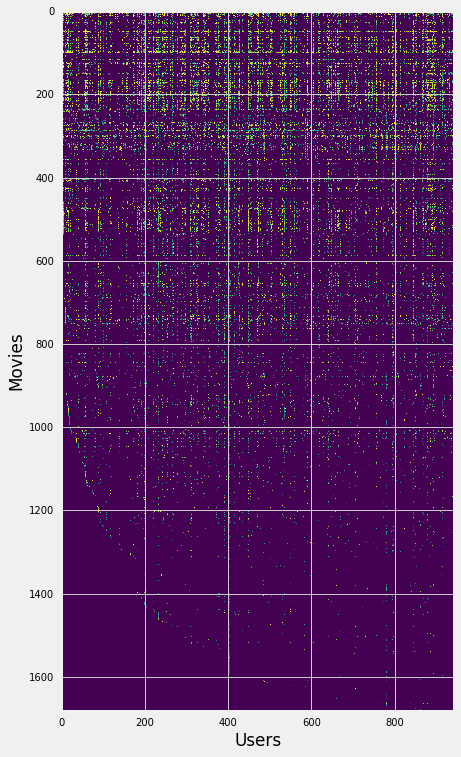

In [8]:
# Load ratings
ratings_data = loadmat("../data/ex8_movies.mat")
Y = ratings_data["Y"]
R = ratings_data["R"]

# Plot ratings matrix as image
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel("Users")
ax.set_ylabel("Movies");

We'll load the movies' titles and store them in a dictionary and put some random ratings for new user on some of the movies to train the collaborative filtering algorithm.

In [9]:
# Put all movies in a dictionary
movies_idx = {}

# Read lines from the text file and add them to the dictionary
# open the file
with open("../data/movie_ids.txt", "r", encoding="ISO-8859-1") as file:
    # read each line
    for line in file:
        # split each line based on white space
        line = line.split(" ")
        # delete space at the end of each movie
        line[-1] = line[-1][:-1]
        # add the movie to the dictionary
        movies_idx[int(line[0]) -1] = " ".join(line[1:])

# Initiate new user"s rating for some movies
ratings = np.zeros((1682, 1)); ratings[0] = 4;
ratings[6] = 3; ratings[11] = 5; ratings[53] = 4;
ratings[63] = 5; ratings[65] = 3; ratings[68] = 5;
ratings[97] = 2; ratings[182] = 4; ratings[225] = 5;
ratings[354] = 5
# print the movies titles that we rated for the new user
print("Rated {0} with {1} stars.".format(movies_idx[0], str(int(ratings[0]))))
print("Rated {0} with {1} stars.".format(movies_idx[6], str(int(ratings[6]))))
print("Rated {0} with {1} stars.".format(movies_idx[11], str(int(ratings[11]))))
print("Rated {0} with {1} stars.".format(movies_idx[53], str(int(ratings[53]))))
print("Rated {0} with {1} stars.".format(movies_idx[63], str(int(ratings[63]))))
print("Rated {0} with {1} stars.".format(movies_idx[65], str(int(ratings[65]))))
print("Rated {0} with {1} stars.".format(movies_idx[68], str(int(ratings[68]))))
print("Rated {0} with {1} stars.".format(movies_idx[97], str(int(ratings[97]))))
print("Rated {0} with {1} stars.".format(movies_idx[182], str(int(ratings[182]))))
print("Rated {0} with {1} stars.".format(movies_idx[225], str(int(ratings[225]))))
print("Rated {0} with {1} stars.".format(movies_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


Finally, we'll normalize ratings matrix and run the algorithm. Using learned $\theta^j$ and $x^i$, we'll try to predict the ratings of all the movies we used to train the algorithm. Moreover, we'll try to sort the ratings of the new user's predicted ratings and print out the top 10 recommended movies along with their predicted ratings.

In [10]:
# Load ratings
ratings_data = loadmat("../data/ex8_movies.mat")
Y = ratings_data["Y"]
R = ratings_data["R"]

# Add new user"s ratings to the original ratings matrix
Y = np.append(ratings, Y, axis=1)
R = np.append((ratings != 0) * 1, R, axis=1)

# Load parameters to use number of users, movies, and features
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Normalize ratings data
Y_mean, Y_normal = normalize_ratings(Y, R)

# Apply collaborative learning algorithm
X, theta = compute_params(Y_normal, R, num_users, num_movies, num_features, 10)

         Current function value: 38976.137563
         Iterations: 100
         Function evaluations: 151
         Gradient evaluations: 151


In [11]:
# compute predictions
predictions = X.dot(theta.T)
# get new users predictions
my_ratings = predictions[:, 0] + Y_mean
# sort the predictions in descending order
idx = np.argsort(my_ratings, axis = 0)[::-1]
# print top 10 movies recommended using the collaboartive filtering algorithm we"ve implemented
print("Top recommendations for you:")
for i in range(10):
    print(f"Predicted rating {my_ratings[idx[i]]:.2f} for {movies_idx[idx[i]]}")

Top recommendations for you:
Predicted rating 5.00 for Aiqing wansui (1994)
Predicted rating 5.00 for Someone Else's America (1995)
Predicted rating 5.00 for Prefontaine (1997)
Predicted rating 5.00 for Saint of Fort Washington, The (1993)
Predicted rating 5.00 for Star Kid (1997)
Predicted rating 5.00 for Great Day in Harlem, A (1994)
Predicted rating 5.00 for They Made Me a Criminal (1939)
Predicted rating 5.00 for Marlene Dietrich: Shadow and Light (1996) 
Predicted rating 5.00 for Entertaining Angels: The Dorothy Day Story (1996)
Predicted rating 5.00 for Santa with Muscles (1996)


We can use those predictions to recommend new movies to users based on their historical preferences. The way to calculate the similarity between movie $i$ and movie $j$ is by computing the euclidean distance as follows:
$$\|x^i - x^j\|$$

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2><br>
* The implementation of the variance/covariance in the detection algorithms has $m$ in the denominator not $(m - 1)$ because with large datasets this doesn't make a difference. However, the unbiased estimator of the variance should have $(m - 1)$ in the denominator not $m$.
* Anomaly detection vs Supervised learning:
    * Use Anomaly Detection when you have large number of negative examples and very small number of positive examples. The reason is because the supervised learning algorithm wouldn't be able to have enough examples to learn about the scene especially if the future anomalies are nothing like training anomalies
    * Use Supervised Learning algorithms such as logistic regression if you have enough positive examples that make the learning easy on the algorithm  and probably it would outperform Anomaly Detection algorithms.  
* Univariate PDF performs well most of the times compared to Multivariate PDF and scale really well.
* Normalize ratings' matrix before applying collaborative filtering algorithm.
    * For new users who don't have any ratings, we use the average rating for each movie that was rated by other users. Therefore, if the average was high, the new user may see that movie recommended for him as a starting point until we start learning his preferences.
* Initialize theta and feature matrices with random values and NOT ZEROS to avoid symmetry.